https://www.kaggle.com/code/akshitmadan/tumor-classification-using-keras-for-beginners


In [1]:
import numpy as np
import pandas as pd
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
# 影像處理的相關套件
# from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #將資料集拆分為訓練集和測試集
from sklearn.preprocessing import OneHotEncoder #獨熱碼
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import cv2
import glob

In [2]:
# 先分類並將yes or no設為獨熱碼
encoder = OneHotEncoder()
encoder.fit([[0], [1]])  # 假設是目標類別的標籤，0=不是 / 1=是

OneHotEncoder()

In [3]:
data = []  # 儲存影像數據
result = []  # 儲存對應的目標標籤

# 載入no的資料，並歸類成0
paths_no = glob.glob("archive/brain_tumor_dataset/no/*")
paths_yes = glob.glob("archive/brain_tumor_dataset/yes/*")

for path in paths_no:
    # img = image.load_img(path, target_size=(128, 128), color_mode="grayscale")
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # 使用灰階模式讀取圖像
    img = cv2.resize(img, (128, 128))  # 調整圖像大小
    img_array = np.expand_dims(img, axis=-1)
    img_array = img_array.astype('float32') / 255.0   # 正規化，將像素縮放到 [0, 1] 之間
    if img_array.shape == (128, 128, 1):
        data.append(img_array) # 將 img_array 加入到 data 列表中
        result.append(encoder.transform([[0]]).toarray())
        

# 載入yes的資料，並歸類成1       
for path in paths_yes:
    # img = image.load_img(path, target_size=(128, 128), color_mode="grayscale")
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # 使用灰階模式讀取圖像
    img = cv2.resize(img, (128, 128))  # 調整圖像大小
    img_array = np.array(img)
    img_array = np.expand_dims(img, axis=-1)
    img_array = img_array.astype('float32') / 255.0 # 正規化，將像素縮放到 [0, 1] 之間
    if img_array.shape == (128, 128, 1):
        data.append(img_array)
        result.append(encoder.transform([[1]]).toarray())


# print(paths_no)
# print(paths_yes) 
print(len(data))
print(len(result))
print(len(paths_no))
print(len(paths_yes))
print(type(data))
print(type(result))

253
253
98
155
<class 'list'>
<class 'list'>


In [4]:
# 將 data result 轉換為 NumPy 陣列
data = np.array(data)
result = np.array(result).reshape(len(result), -1)
print(result.shape) # 應該要是155行，內容是 [0,1], [1,0]

#  33% 的資料留給測試集，67% 的資料用於訓練集，分割資料前打亂資料集，確保每次打亂分割的結果一致
x_train, x_test, y_train, y_test = train_test_split(data, result, test_size=0.33, shuffle=True, random_state=0)
print("x, y_train shape:", x_train.shape, y_train.shape)
print("x, y_test shape:", x_test.shape, y_test.shape)

(253, 2)
x, y_train shape: (169, 128, 128, 1) (169, 2)
x, y_test shape: (84, 128, 128, 1) (84, 2)


In [5]:
# 宣告循序建模型
model = Sequential()

# 第一組卷積層：包含卷積層、批次標準化層、最大池化層和 Dropout
# 卷積層包含 32 個filter，每個filter的大小為 (2, 2)
# padding='Same' 確保輸入和輸出的尺寸相同
# 增加激活函數 ReLu
model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 1), padding='Same'))
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', padding='Same'))

# 批次標準化層，用來提高模型的訓練穩定性和收斂速度
model.add(BatchNormalization())

# 池化層，用來抓取重要特徵去第重要部分，減小特徵圖的尺寸
model.add(MaxPooling2D(pool_size=(2, 2)))

# 防止過擬合，丟棄率為 25%
model.add(Dropout(0.25))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4128      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
Total params: 4,416
Trainable params: 4,352
Non-trainabl

In [6]:
# 第二組卷積層：包含卷積層、批次標準化層、最大池化層和 Dropout
# 拉平層，將先前的卷積層的輸出拉平為一維向量
model.add(Flatten())
# 連接至全連接層Full Connected Layer，包含 512 個神經元，使用 ReLU 激活函數
model.add(Dense(512, activation='relu'))
# 防止過擬合，丟棄率為 25%
model.add(Dropout(0.5))
# 連接至全連接層，包含 2 個神經元，使用 softmax 激活函數，用於2個類別分類
model.add(Dense(2, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4128      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 flatten (Flatten)           (None, 131072)            0

In [7]:
# 編譯模型
# 損失函數：categorical_crossentropy 常用於多類別分類問題
# 梯度下降方式(優化)：Adamax adam隨機梯度下降的變種，用於最小化損失
# 量測標準：accuracy
model.compile(loss="categorical_crossentropy", optimizer='Adamax', metrics=["accuracy"])


In [8]:
y_train.shape


(169, 2)

In [9]:
history = model.fit(x_train, y_train, epochs = 30, batch_size = 40, verbose = 1,validation_data = (x_test, y_test))

# 訓練資料的特徵, 訓練資料的標籤, epoch為30回合, batch_size為批量40數，verbose顯示模式為0(0:安靜模式/1:顯示進度條), 

Epoch 1/30
5/5 [==============================] - 20s 2s/step - loss: 58.2614 - accuracy: 0.6154 - val_loss: 0.9243 - val_accuracy: 0.8214
Epoch 2/30
5/5 [==============================] - 7s 1s/step - loss: 19.9493 - accuracy: 0.6686 - val_loss: 0.8620 - val_accuracy: 0.7024
Epoch 3/30
5/5 [==============================] - 7s 1s/step - loss: 6.4880 - accuracy: 0.8047 - val_loss: 0.9599 - val_accuracy: 0.6310
Epoch 4/30
5/5 [==============================] - 7s 1s/step - loss: 3.5358 - accuracy: 0.8107 - val_loss: 0.6252 - val_accuracy: 0.7381
Epoch 5/30
5/5 [==============================] - 7s 1s/step - loss: 1.7379 - accuracy: 0.8402 - val_loss: 0.5538 - val_accuracy: 0.7500
Epoch 6/30
5/5 [==============================] - 7s 1s/step - loss: 0.9603 - accuracy: 0.8580 - val_loss: 0.5277 - val_accuracy: 0.7619
Epoch 7/30
5/5 [==============================] - 7s 1s/step - loss: 0.3768 - accuracy: 0.9408 - val_loss: 0.5488 - val_accuracy: 0.7381
Epoch 8/30
5/5 [======================

In [10]:
loss, accuracy = model.evaluate(x_train, y_train)
print("訓練集的準確度 = {:.2f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test)
print("測試集的準確度 = {:.2f}".format(accuracy))


6/6 [==============================] - 1s 193ms/step - loss: 0.2219 - accuracy: 1.0000
訓練集的準確度 = 1.00
3/3 [==============================] - 1s 158ms/step - loss: 0.4978 - accuracy: 0.8333
測試集的準確度 = 0.83


In [11]:
# 顯示訓練和驗證損失
## 訓練集中損失的值
loss = history.history["loss"]
## 訓練週期的數量為 1~30，表示X軸
epochs = range(1, len(loss)+1)
## 測試集中損失的值
val_loss = history.history["val_loss"]

print(loss)
print(epochs)
print(val_loss)

[58.26144027709961, 19.949331283569336, 6.4880242347717285, 3.5357799530029297, 1.7378751039505005, 0.960271954536438, 0.3768332302570343, 0.5667168498039246, 0.2911335825920105, 0.18570664525032043, 0.2119968831539154, 0.05546468868851662, 0.06185614690184593, 0.04815637320280075, 0.05784336477518082, 0.017081674188375473, 0.021952947601675987, 0.048681288957595825, 0.02944810315966606, 0.05652434378862381, 0.011785894632339478, 0.02564743347465992, 0.008319126442074776, 0.013140414841473103, 0.024204730987548828, 0.006242028437554836, 0.020726440474390984, 0.013691563159227371, 0.04557322710752487, 0.006600382272154093]
range(1, 31)
[0.9242518544197083, 0.8620390892028809, 0.9598554968833923, 0.6252127885818481, 0.5538374781608582, 0.5276862978935242, 0.5488286018371582, 0.5313379168510437, 0.5292136669158936, 0.5380908250808716, 0.5448547601699829, 0.5327847599983215, 0.5247723460197449, 0.5202077627182007, 0.5165160894393921, 0.5154297947883606, 0.5107422471046448, 0.50987869501113

<function matplotlib.pyplot.show(close=None, block=None)>

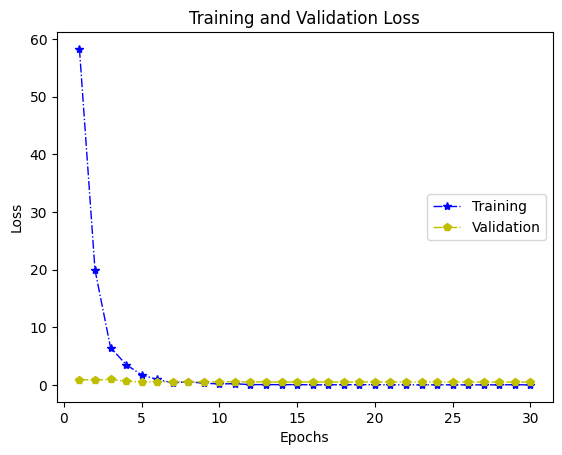

In [12]:
# 畫出圖表分析訓練過程
plt.plot(epochs, loss, color="b", lw=1.0, ls="-.", marker="*", label="Training Loss")
plt.plot(epochs, val_loss, color="y", lw=1.0, ls="-.", marker="p", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training', 'Validation'], loc='right')
plt.show

In [20]:
from sklearn.metrics import multilabel_confusion_matrix
# 找出模型的預測答案
# 對測試集進行預測
y_pred = (model.predict(x_test) > 0.5).astype(int)  # 使用閾值0.5，假設是二元分類

# 計算混淆矩陣
conf_matrix = multilabel_confusion_matrix(y_test, y_pred)

# 計算其他性能指標
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

# 輸出結果
print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

3/3 [==============================] - 1s 189ms/step
Confusion Matrix:
[[[43 10]
  [ 4 27]]

 [[27  4]
  [10 43]]]
Accuracy: 0.83
Precision: 0.83
Recall: 0.83
F1 Score: 0.83


<function matplotlib.pyplot.show(close=None, block=None)>

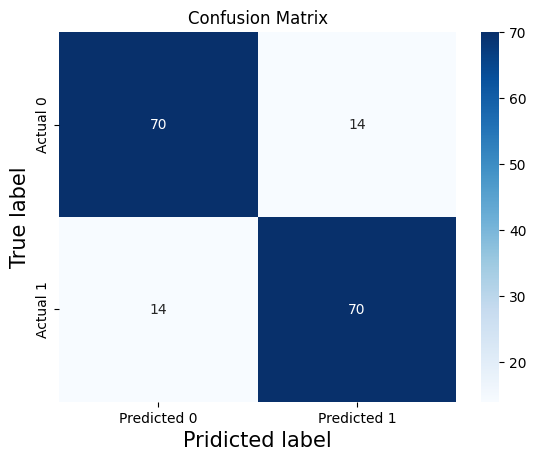

In [25]:
# 轉成 datafram
# matrix_df=pd.DataFrame(conf_matrix)
# 利用plot設定輸出格式
# ax = plt.axes()
# 修改字體比例
# sns.set(font_scale=1.3)
# plt.figure(figsize=(10,7))

# 綜合多標籤混淆矩陣
combined_conf_matrix = conf_matrix.sum(axis=0)

# 顯示混淆矩陣
fig, ax = plt.subplots()
sns.heatmap(combined_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

# sns.heatmap(matrix_df,annot=True,fmt="g",ax=ax, cmap="magma")
# 設定標題，x,y軸的文字
ax.set_title('Confusion Matrix')
ax.set_xlabel("Pridicted label", fontsize=15)
# ax.set_xticklabels(list(labels))
ax.set_ylabel("True label", fontsize=15)
# ax.set_yticklabels(list(labels), rotation =0)
plt.show

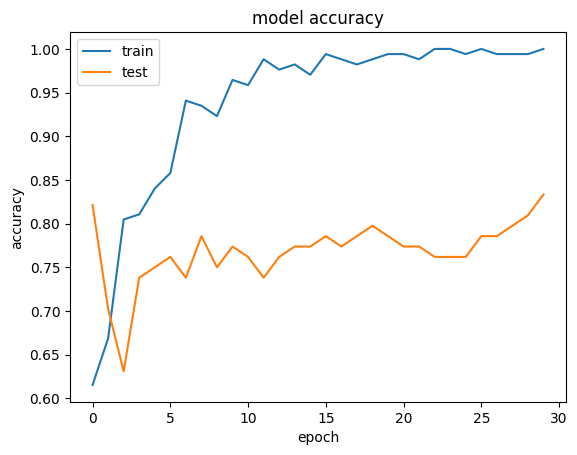

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()